This notebook contains code to visualize joint method validation using a beeswarm plot

In [1]:
%pylab inline
import seaborn as sns
import pandas as pd
import glob
import numpy as np
import sys
sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from Joint_method_functions import *
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
PLOTDIR = '/storage/BonnieH/selection_project/figures/supp_figures/'

Populating the interactive namespace from numpy and matplotlib


In [2]:
def main():    
    plt.rcParams["axes.labelsize"] = 15
    print('Running main')
    means = [10**-5, 10**-4, 10**-3, 10**-2] 
    pers = [2,3,4]
    opt_dic = {}
    opt_dic[2] = [11,20] 
    opt_dic[3] = [5,13] 
    opt_dic[4] = [7,10] 
    folder = 't1'  
    fig_num = 0
    
    ab_pairs = []
    a_values = []
    dic = {}
    dic['Period, Optimal allele'] = []
    dic['Ground truth a,b'] = []
    dic['Ground truth a'] = []
    dic['s values'] = []
    dic['Fraction of loci'] = []
    
    for per in pers:
        for opt in opt_dic[per]:
            print('Running period %d opt %d'%(per,opt))
            for mean in means:
                for j in range(0,3):

                    file_list = glob.glob('/gymreklab-tscc/bonnieh/heatmap/results_validation_ks_test/%s/per_%d_opt_%d_*eurodem_prior2*_%.8f.txt'%(folder, per, opt, mean)) 
                    file_list.sort()
                       
                    filename = file_list[j]
                    allele_freqs_file = open(filename, 'r')
                    lines = allele_freqs_file.readlines()

                    # Line 6 is list of accepted medians
                    line = lines[6]       
                    info = line.strip().split(': ')
                    if len(info) > 1: 
                        params = info[1]
                        params = params.strip().split('), ')
                        params_list = []
                        for param in params:
                            param = param[1:]
                            if param[-1] == ')':
                                param = param[:-1]
                            param = param.strip().split(', ')
                            params_list.append(((float(param[1])), float(param[2])))

                        # Line 1 is information of k, theta used
                        line = lines[1]
                        info = line.strip().split(' ')
                        k = float(info[7])
                        theta = float(info[10])

                        if (k, theta) not in ab_pairs:
                            ab_pairs.append((k,theta))

                        if k not in a_values:
                            a_values.append(k)
                        
                        for param in params_list:
                            # Get list of binned s values
                            # Bins: 0<=s<10^-4, 10^-4<=s<10^-3, 10^-3<=s<10^-2, s>=10^-2
                            svals = GetGammaBins(param[0], param[1], 1000)
                            combos = [('0<=s<10^-4',svals[0]),('10^-4<=s<10^-3',svals[1]),('10^-3<=s<10^-2',svals[2]),('s>=10^-2',svals[3])]
                            for combo in combos:
                                
                                dic['Period, Optimal allele'].append('Per %d Opt %d'%(per, opt))
                                dic['Ground truth a,b'].append('(%.1E,%.1E)'%(k,theta))
                                dic['Ground truth a'].append(k)
                                dic['s values'].append('%.1E %s'%(theta,combo[0]))
                                dic['Fraction of loci'].append(combo[1])
                            
    df = pd.DataFrame(data=dic)
    df.to_csv('joint_validation.txt', sep = '\t', index=False)
    for a_value in a_values:
        
        sub_df = df.loc[df['Ground truth a'] == a_value]
        
        # Plot beeswarm plot
        fig_num = fig_num + 1
        plt.figure(fig_num, figsize=(18, 6)) 
        z=sns.swarmplot(x="s values", y="Fraction of loci", hue="Period, Optimal allele", data=sub_df, palette=['deepskyblue','blue','lightgreen','green','lightpink','deeppink'])
        z.tick_params(labelsize=15)
        #z.set_yticklabels(z.get_yticks(), size = 15)
        plt.ylim(-0.1, 1.1)
        k = a_value
        i = -1
        xpos = range(0,16)
        xlabels = ['0<=s<10^-4','10^-4<=s<10^-3','10^-3<=s<10^-2','s>=10^-2'] * 4
        xlabels = ['0'+r'$\leq$'+'s<'+r'$10^{-4}$',r'$10^{-4}$'+r'$\leq$'+'s<'+r'$10^{-3}$',r'$10^{-3}$'+r'$\leq$'+'s<'+r'$10^{-2}$','s'+r'$\geq$'+r'$10^{-2}$'] * 4

        thetas = []
        for mean in means:
            theta = mean/k
            thetas.append(theta)
            mean_s = k*theta
            if mean_s < 10**-5:
                mean_s = 10**-5
        
            svals =  GetGammaBins(k, theta, 1000)
            i = i + 1
            plt.plot(i, svals[0], marker='*', markersize=20, c = 'black', zorder=10) 
            i = i + 1
            plt.plot(i, svals[1], marker='*', markersize=20, c = 'black', zorder=10)
            i = i + 1
            plt.plot(i, svals[2], marker='*', markersize=20, c = 'black', zorder=10) 
            i = i + 1
            plt.plot(i, svals[3], marker='*', markersize=20, c = 'black', zorder=10)
            
        plt.xticks(xpos, xlabels, rotation = 35, size = 15)
        plt.title('Joint method validation \n a = %.1f'%(k),size=15)
        plt.axvline(x=3.5, linestyle = '--',c='black')
        plt.axvline(x=7.5, linestyle = '--',c='black')
        plt.axvline(x=11.5, linestyle = '--',c='black')
        #plt.text(1,-0.4,'b=' + '%.1E'%(thetas[0]),size=15)
        #plt.text(5,-0.4,'b=' + '%.1E'%(thetas[1]),size=15)
        #plt.text(9,-0.4,'b=' + '%.1E'%(thetas[2]),size=15)
        #plt.text(13,-0.4,'b=' + '%.1E'%(thetas[3]),size=15)
        text_pos = -0.5
        plt.text(1,text_pos,'Mean s=' + r'$10^{-5}$',size=15)
        plt.text(5,text_pos,'Mean s=' + r'$10^{-4}$',size=15)
        plt.text(9,text_pos,'Mean s=' + r'$10^{-3}$',size=15)
        plt.text(13,text_pos,'Mean s=' + r'$10^{-2}$',size=15)
        
        plt.xlabel("S value bins", labelpad=30,size=15)
        #plt.savefig(PLOTDIR + 'validation_beeswarm_a_%.1f_genotyping_errors.pdf'%(a_value), bbox_inches='tight')
        plt.legend(bbox_to_anchor=(1, 1),fontsize=15)#

Running main
Running period 2 opt 11
Running period 2 opt 20
Running period 3 opt 5
Running period 3 opt 13
Running period 4 opt 7
Running period 4 opt 10
CPU times: user 20.6 s, sys: 105 ms, total: 20.7 s
Wall time: 21 s


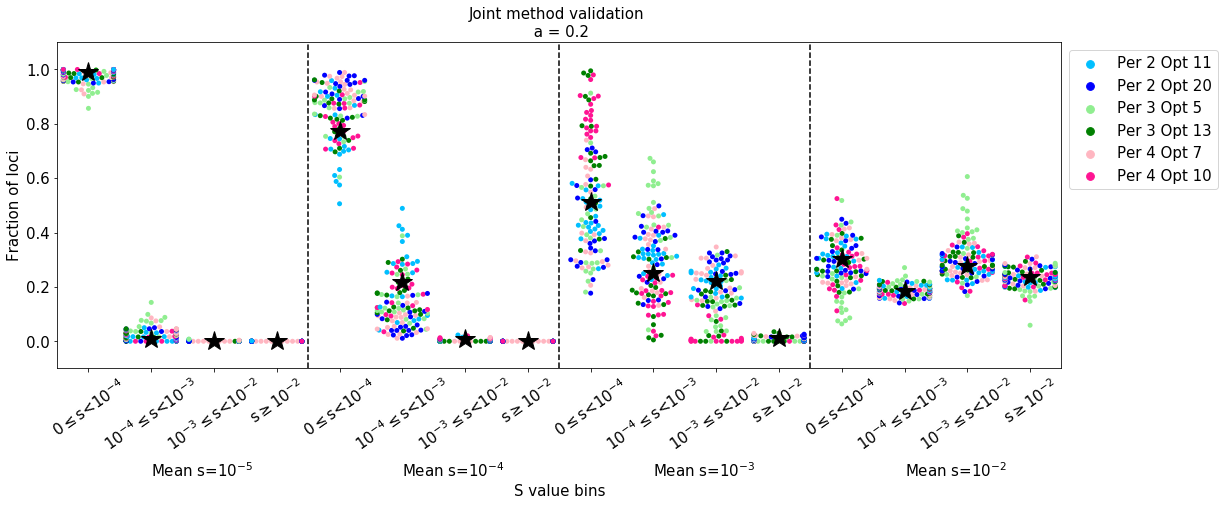

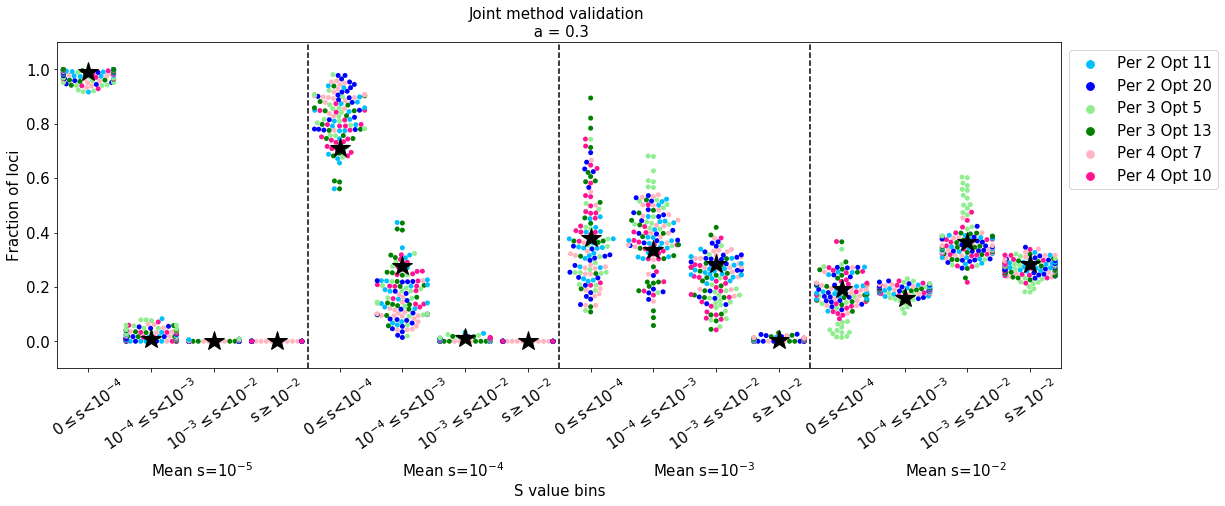

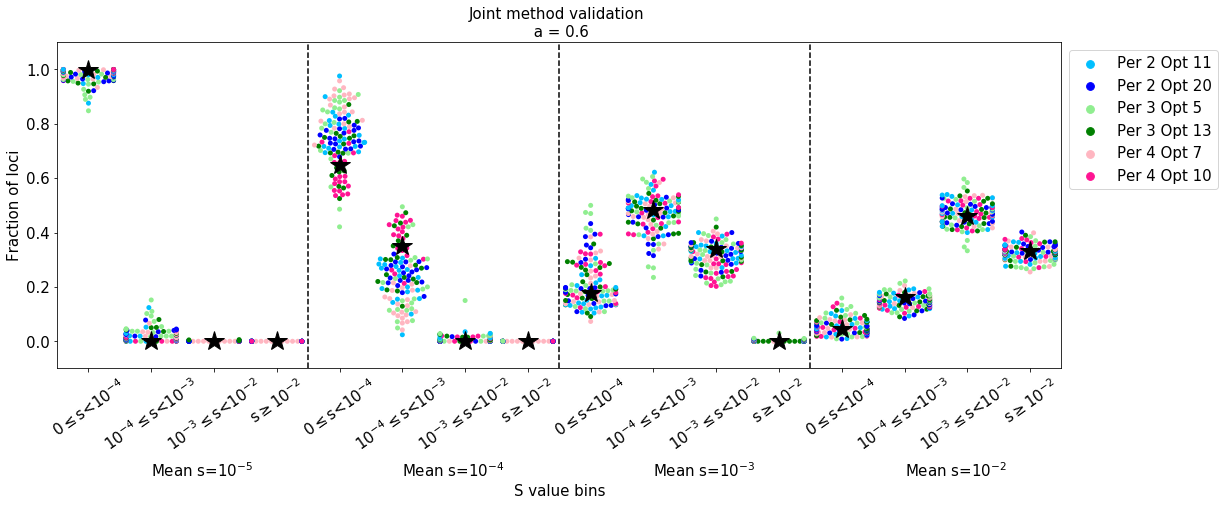

In [3]:
%%time
if __name__ == '__main__':
    main()